# <font color="#0000cd">SSDの中身が意味プなのでがんばって解剖してみたい件</font>
***
## <font color="#4169e1">non maximum suppressionの実装</font>
    1. Conjugate Contours : coords
        座標をもとにバウンディングボックスを結合する    
    2. Conjugate Contours : areas
        面積の重複が閾値を超えたら削除する
    3. non maximum suppression : Python
        Pythonでのnon maximum suppressionの実装
    4. non maximum suppression : tensorflow
        tensorflowで実装されているnon maximum suppression

## 1. Conjugate Contours : coords

In [1]:
import datetime
import cv2
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
contours = [
    [782, 363, 53, 31], [752, 360, 58, 18], [800, 600, 100, 125], [779, 349, 20, 10], 
    [816, 294, 77, 52], [1042, 247, 139, 91], [1079, 171, 84, 132], [1141, 161, 67, 62], 
    [488, 126, 44, 43], [702, 121, 50, 48], [721, 108, 59, 64], [606, 90, 21, 31], 
    [896, 75, 1, 1], [897, 70, 1, 1], [590, 30, 24, 27], [616, 17, 94, 94], [349, 0, 666, 652]]

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


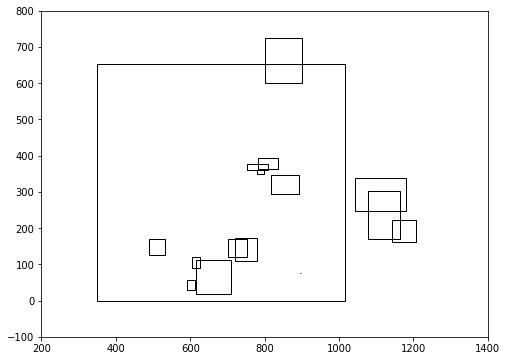

In [3]:
fig = plt.figure(figsize=(8,6))
plt.xlim(200, 1400)
plt.ylim(-100, 800)
ax = fig.add_subplot(111)

for i in contours:
    rect = plt.Rectangle((i[0],i[1]),i[2],i[3], fill=False)
    ax.add_patch(rect)
plt.show()

In [4]:
def draw_image(contours):
    old=datetime.datetime.now()
    fig = plt.figure(figsize=(8,6))
    plt.xlim(200, 1400)
    plt.ylim(-100, 800)
    ax = fig.add_subplot(111)

    for i in contours:
        rect = plt.Rectangle((i[0],i[1]),i[2],i[3], fill=False)
        ax.add_patch(rect)
    for i in conjugate_contours(contours):
        rect = plt.Rectangle((i[0],i[1]),i[2],i[3], fill=False, edgecolor='#ff0000')
        #rect = plt.Rectangle((i[0],i[1]),i[2]-i[0],i[3]-i[1], fill=False, edgecolor='#ff0000')
        ax.add_patch(rect)    
    
    print('-------------------------------------------------------')
    print('・cost time : ',(datetime.datetime.now()-old))
    print('-------------------------------------------------------')
    
    return plt.show()

In [5]:
def conjugate_contours(contours):
    # 固定座標のインデックス, 無限ループを終えるための変数を設定
    index = 0
    stop = 0

    while (index < len(contours) and stop < 5):
        # 比較座標は固定座標の右隣からスタート
        step = 1

        # 一周したらリセット(最後がFalseで終了)
        if index + 1 == len(contours):
            index = 0
            stop += 1

        while (index + step < len(contours)):
            # 固定座標
            xmin = contours[index][0]
            ymin = contours[index][1]
            xmax = contours[index][2] + xmin
            ymax = contours[index][3] + ymin

            # 比較座標
            cxmin = contours[index + step][0]
            cymin = contours[index + step][1]
            cxmax = contours[index + step][2] + cxmin
            cymax = contours[index + step][3] + cymin

            # AがBを含む、もしくはAがBに含まれる場合
            if (xmin <= cxmin <= xmax or xmin <= cxmax <= xmax or cxmin <= xmin <= cxmax or cxmin <= xmax <= cxmax)\
                and (ymin <= cymin <= ymax or ymin <= cymax <= ymax or cymin <= ymin <= cymax or cymin <= ymax <= cymax):

                    # 統合された座標
                    nxmin = min(xmin, cxmin)
                    nymin = min(ymin, cymin)
                    nxmax = max(xmax, cxmax)
                    nymax = max(ymax, cymax)

                    # 固定座標を統合座標で更新
                    contours[index] = [nxmin, nymin, nxmax-nxmin, nymax-nymin]

                    # 比較座標を削除
                    contours.pop(index + step)

                    # 一周したらリセット(最後がTrueで終了)
                    if step == 1 and index + step == len(contours):
                        index = 0
                        step = 1
                        
            # どちらにも含まれない場合、比較座標を1つずらす
            else:
                step += 1

        # 重なるboxがなくなったら固定座標を1つずらす
        else:
            index += 1    
    
    return contours

-------------------------------------------------------
・cost time :  0:00:00.071011
-------------------------------------------------------


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


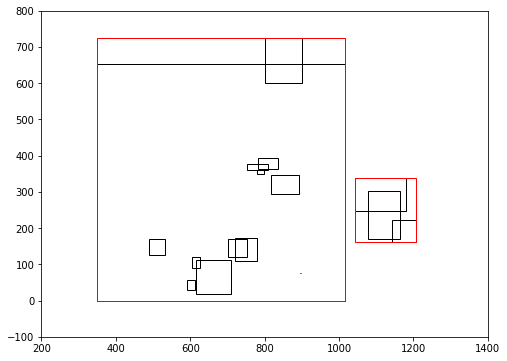

In [6]:
draw_image(contours)

## 2. Conjugate Contours : areas

In [7]:
def non_max_suppression_slow(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0] # xmin
    y1 = boxes[:,1] # ymin
    x2 = boxes[:,2] # xmax
    y2 = boxes[:,3] # ymax

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2) # ymaxの値を昇順, [0, 2, 1]
    print('idxs', idxs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1 # index of biggest ymax in sort boxes
        i = idxs[last] # index of biggest ymax in boxes
        pick.append(i) # pick = [1]
        suppress = [last] # suppress = [2]

        # loop over all indexes in the indexes list
        for pos in range(0, last): # last = 2
            # grab the current index
            j = idxs[pos]

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1) # 接触していなければ0
            h = max(0, yy2 - yy1 + 1)

            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]

            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)

        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)

    # return only the bounding boxes that were picked
    return boxes[pick]

original :  ((120, 10), 1001, 801)
original :  ((240, 100), 1151, 1001)
original :  ((300, 250), 801, 751)
idxs [0 2 1]
-------------------------------------------------------
・cost time :  0:00:00.000598
-------------------------------------------------------
after nms :  ((240, 100), 1151, 1001)


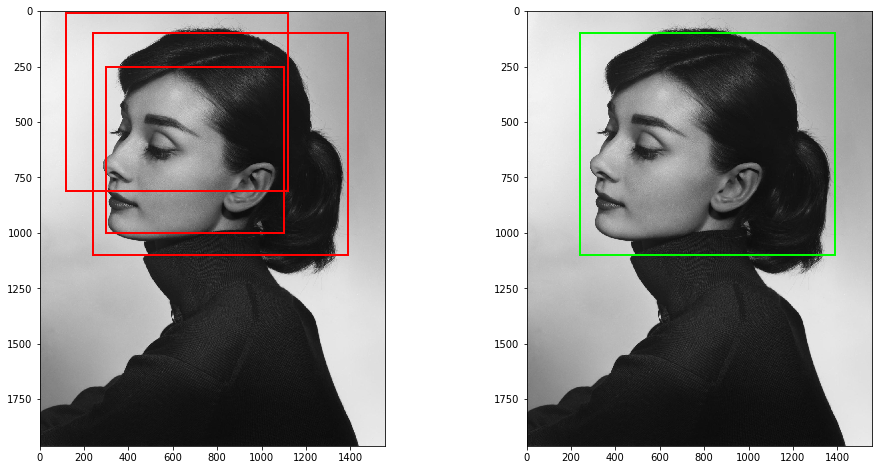

In [8]:
images = [
    ("audrey.jpg", np.array([
    (120, 10, 1120, 810),
    (240, 100, 1390, 1100),
    (300, 250, 1100, 1000)]))]

for (imagePath, boundingBoxes) in images:
    
    # originalのbounding boxを描画（左図）
    image = cv2.imread("audrey.jpg")
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    #plt.axis('off')
    currentAxis = plt.gca()
    
    for xmin, ymin, xmax, ymax in boundingBoxes:
        coords = (xmin, ymin), xmax - xmin +1, ymax - ymin +1
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='#ff0000', linewidth=2))
        print('original : ', coords)
    
    # after non maximum suppressionのbounding boxを描画（右図）
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    #plt.axis('off')
    currentAxis = plt.gca()
    
    old=datetime.datetime.now()
    pick = non_max_suppression_slow(boundingBoxes, 0.3)
    print('-------------------------------------------------------')
    print('・cost time : ',(datetime.datetime.now()-old))
    print('-------------------------------------------------------')
    
    for xmin, ymin, xmax, ymax in pick:
        coords = (xmin, ymin), xmax - xmin +1, ymax - ymin +1
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='#00ff00', linewidth=2))
        print('after nms : ', coords)
        
    

## 3. non maximum suppression : Python

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


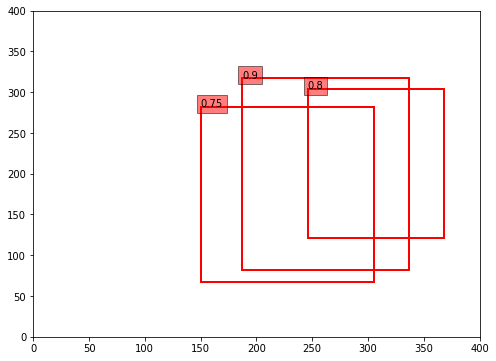

In [9]:
coords = [[187, 82, 337, 317],[150, 67, 305, 282],[246, 121, 368, 304]]
bounding_boxes = [[187, 82, 337-187, 317-82],[150, 67, 305-150, 282-67],[246, 121, 368-246, 304-121]]
confidence_score = [0.9, 0.75, 0.8]

fig = plt.figure(figsize=(8,6))
plt.xlim(0, 400)
plt.ylim(0, 400)
ax = fig.add_subplot(111)

for label, i in enumerate(bounding_boxes):
    # rect = plt.Rectangle((i[0],i[1]),i[2],i[3], fill=False)
    coords = (i[0], i[1]), i[2], i[3]
    plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='#FF0000', linewidth=2))
    plt.gca().text(i[0], i[1]+i[3], str(confidence_score[label]), bbox={'facecolor':'#FF0000', 'alpha':0.5})
    #ax.add_patch(rect)
plt.show()

-------------------------------------------------------
・cost time :  0:00:00.000605
-------------------------------------------------------


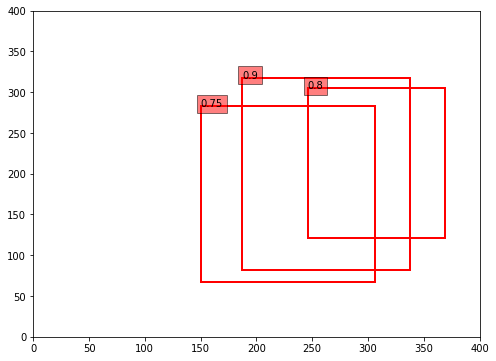

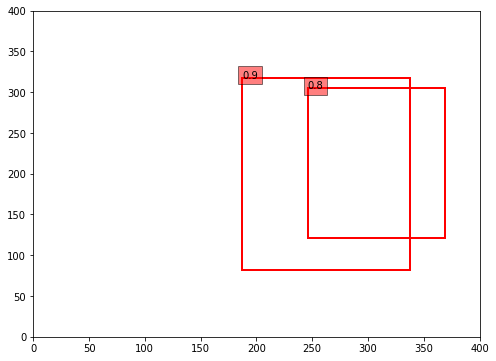

In [10]:
def nms(bounding_boxes, score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], [] # picked boxes, picked scores
    
    # coordinates of bounding boxes
    start_x = bounding_boxes[:, 0]
    start_y = bounding_boxes[:, 1]
    end_x = bounding_boxes[:, 2]
    end_y = bounding_boxes[:, 3]

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []
    intersection_areas = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)
    
    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]
        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])
        intersection_areas.append([x1, y1, x2, y2])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score, intersection_areas

bounding_boxes =np.asarray([[187, 82, 337, 317],[150, 67, 305, 282],[246, 121, 368, 304]],dtype=np.float32)
confidence_score = np.asarray([0.9, 0.75, 0.8],dtype=np.float32)

# IoU threshold
threshold = 0.5

old=datetime.datetime.now()
picked_boxes, picked_score, intersection_areas = nms(bounding_boxes, confidence_score, threshold)
print('-------------------------------------------------------')
print('・cost time : ',(datetime.datetime.now()-old))
print('-------------------------------------------------------')
    


#print('nms : ', picked_boxes,picked_score)

fig = plt.figure(figsize=(8,6))
plt.xlim(0, 400)
plt.ylim(0, 400)
#ax1 = fig.add_subplot(121)
#ax2 = fig.add_subplot(122)

for label, i in enumerate(bounding_boxes):
    # rect = plt.Rectangle((i[0],i[1]),i[2],i[3], fill=False)
    coords = (i[0], i[1]), i[2]-i[0]+1, i[3]-i[1]+1
    inter_xmin = intersection_areas[0][0][0]
    inter_ymin = intersection_areas[0][1][0]
    inter_xmax = intersection_areas[0][2][0]
    inter_ymax = intersection_areas[0][3][0]
    inter_coords = (inter_xmin, inter_ymin), inter_xmax-inter_xmin+1, inter_ymax-inter_ymin+1
    plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='#FF0000', linewidth=2))
    #plt.gca().add_patch(plt.Rectangle(*inter_coords, fill=True, facecolor={'facecolor':'#FF0000','alpha':0.5}, edgecolor='#FF0000', linewidth=0))
    plt.gca().text(i[0], i[3], str(confidence_score[label]), bbox={'facecolor':'#FF0000', 'alpha':0.5})
    #ax.add_patch(rect)
#plt.show()

fig = plt.figure(figsize=(8,6))
plt.xlim(0, 400)
plt.ylim(0, 400)
#plt.subplot(1,2,2)
for label, i in enumerate(picked_boxes):
    rect = plt.Rectangle((i[0],i[1]),i[2],i[3], fill=False)
    coords = (i[0], i[1]), i[2]-i[0]+1, i[3]-i[1]+1
    plt.gca().add_patch(plt.Rectangle(*coords, fill=False, edgecolor='#FF0000', linewidth=2))
    plt.gca().text(i[0], i[3], str(picked_score[label]), bbox={'facecolor':'#FF0000', 'alpha':0.5})
    #ax.add_patch(rect)
#plt.subplot(1,2,2)

#plt.show()
#print(intersection_areas)
#print(intersection_areas[0][0])

## 4. non maximum suppression : tensorflow
    Predictionsとして数千のバウンディングボックスの座標が出力される
    →max_output_sizeとして定めた値まで減らす

In [11]:
# non maximum suppression : Python
print(picked_boxes, picked_score)

[array([187.,  82., 337., 317.], dtype=float32), array([246., 121., 368., 304.], dtype=float32)] [0.9, 0.8]


In [13]:
import tensorflow as tf

threshold = 0.5

with tf.Session() as sess:

    for i in range(3): # forなしだと、nms.eval()がエラー、expected an indented block
        old=datetime.datetime.now()
        nms = tf.image.non_max_suppression(bounding_boxes,confidence_score, max_output_size=5, iou_threshold=threshold)
        print('-------------------------------------------------------')
        print('・cost time : ',(datetime.datetime.now()-old)) # .microseconds
        print('・face detected : ', len(nms.eval()))
        
        for index, value in enumerate(nms.eval()): # nms.eval() → インデックスを返す
            rect = bounding_boxes[value]
            print('・value : ', value)
            print('・rect : ', rect)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


-------------------------------------------------------
・cost time :  0:00:00.021850
・face detected :  2
・value :  0
・rect :  [187.  82. 337. 317.]
・value :  2
・rect :  [246. 121. 368. 304.]
-------------------------------------------------------
・cost time :  0:00:00.002580
・face detected :  2
・value :  0
・rect :  [187.  82. 337. 317.]
・value :  2
・rect :  [246. 121. 368. 304.]
-------------------------------------------------------
・cost time :  0:00:00.002657
・face detected :  2
・value :  0
・rect :  [187.  82. 337. 317.]
・value :  2
・rect :  [246. 121. 368. 304.]


# <font color="#4169e1">感想</font>
***
    ・tensorflow作ったひとすごい
    ・SSD作ったひともすごい
    ・車輪の再発明も勉強になるから悪くない
    ・1つ1つ処理せずに行列でまとめて処理したほうが確かにスーパー早い
    ・nmsしてもmax_output_sizeを200とかにしてるから画面がバウンディングボックスで埋まる
    ・テスト画像にオードリーヘップバーンを使うとテンション上がる
    ・引き続きSSDを解明していきたい